**Assignment 2** 

This assignment requires you to implement image recognition methods. Please understand and use relevant libraries. You are expected to solve both questions.

**Data preparation and rules**

Please use the images of the MNIST hand-written digits recognition dataset. You may use torchvision.datasets library to obtain the images and splits. You should have 60,000 training images and 10,000 test images. Use test images only to evaluate your model performance.


In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split


Q2: CNNs and Transformers [6 points]
1. [2.5 points] Set up a modular codebase for training a CNN (LeNet) on the task of handwritten digit recognition. You should have clear functional separation between the data (dataset and dataloader), model (nn.Module), and trainer (train/test epoch loops). Implement logging: using Weights & Biases is highly recommended, alternatively, create your own plots using other plotting libraries. Log the training and evaluation losses and accuracies at every epoch, show the plots for at least one training and evaluation run.
Note 1: Seed random numbers for reproducibility (running the notebook again should give you the same results!).


In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def load_data(batch_size=64):
    transform = transforms.Compose([transforms.Resize((32, 32)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,))])

    # Download and load the training data
    trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

    # Download and load the test data
    testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

    return trainloader, testloader


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sunayana-samavedam (sunayana981). Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Epoch 1/10.. Train loss: 0.234.. Test loss: 0.073.. Test accuracy: 0.976
Epoch 2/10.. Train loss: 0.064.. Test loss: 0.060.. Test accuracy: 0.981
Epoch 3/10.. Train loss: 0.045.. Test loss: 0.037.. Test accuracy: 0.988
Epoch 4/10.. Train loss: 0.037.. Test loss: 0.035.. Test accuracy: 0.988
Epoch 5/10.. Train loss: 0.030.. Test loss: 0.039.. Test accuracy: 0.987
Epoch 6/10.. Train loss: 0.024.. Test loss: 0.037.. Test accuracy: 0.989
Epoch 7/10.. Train loss: 0.023.. Test loss: 0.034.. Test accuracy: 0.989
Epoch 8/10.. Train loss: 0.018.. Test loss: 0.046.. Test accuracy: 0.987
Epoch 9/10.. Train loss: 0.016.. Test loss: 0.044.. Test accuracy: 0.986
Epoch 10/10.. Train loss: 0.014.. Test loss: 0.035.. Test accuracy: 0.990


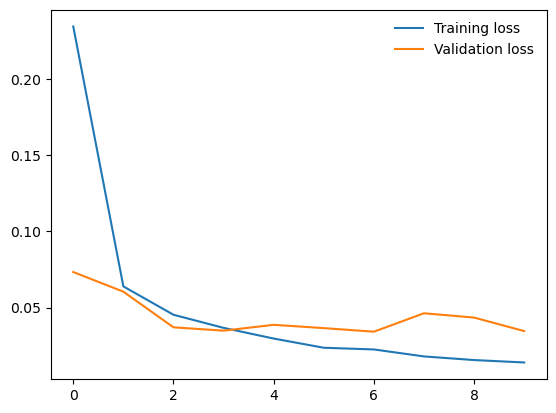

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import wandb  # Import wandb

# Initialize wandb
wandb.init(project="lenet_mnist_project", entity="sunayana981")

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) # Input channel, Output channels, Kernel size
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def train_and_evaluate(model, trainloader, testloader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Log hyperparameters
    wandb.config = {
        "learning_rate": 0.001,
        "epochs": epochs,
        "batch_size": trainloader.batch_size
    }

    train_losses, test_losses = [], []
    for e in range(epochs):
        running_loss = 0
        for images, labels in trainloader:
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        else:
            test_loss = 0
            accuracy = 0

            with torch.no_grad():
                model.eval()
                for images, labels in testloader:
                    log_ps = model(images)
                    test_loss += criterion(log_ps, labels)

                    ps = torch.exp(log_ps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

            model.train()
            train_loss = running_loss/len(trainloader)
            test_loss = test_loss/len(testloader)
            accuracy = accuracy/len(testloader)
            
            train_losses.append(train_loss)
            test_losses.append(test_loss)

            # Log losses and accuracy
            wandb.log({"train_loss": train_loss,
                       "test_loss": test_loss,
                       "accuracy": accuracy})

            print(f"Epoch {e+1}/{epochs}.. "
                  f"Train loss: {train_loss:.3f}.. "
                  f"Test loss: {test_loss:.3f}.. "
                  f"Test accuracy: {accuracy:.3f}")
            
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.show()

if __name__ == "__main__":
    torch.manual_seed(42)  # For reproducibility
    # Initialize wandb
    wandb.login()  # Ensure you are logged in to wandb
    trainloader, testloader = load_data()
    model = LeNet()
    # Add the model to wandb
    wandb.watch(model, log="all")
    train_and_evaluate(model, trainloader, testloader)
    torch.save(model.state_dict(), 'lenet_mnist.pth')
    wandb.save('lenet_mnist.pth')  # Optionally, save model to wandb


2. [1 point] Show the results for 6 different settings of hyperparameters. You may want to change the batch size, learning rate, and optimizer. Explain the trends in classification accuracy that you observe. Which hyperpa- rameters are most important?


In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import wandb  # Import wandb
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) # Input channel, Output channels, Kernel size
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



def train_and_evaluate_with_wandb(config, epochs=5):
    wandb.init(project="mnist_grid_search", config=config)
    
    # Load and preprocess the MNIST dataset
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=config['batch_size'], shuffle=True)
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = DataLoader(testset, batch_size=config['batch_size'], shuffle=False)

    # Model instantiation
    model = LeNet()
    criterion = nn.CrossEntropyLoss()

    # Optimizer selection based on config
    if config['optimizer_choice'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config.get('weight_decay', 0.0))
    elif config['optimizer_choice'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=config.get('momentum', 0.9), weight_decay=config.get('weight_decay', 0.0))
    elif config['optimizer_choice'] == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=config['learning_rate'], weight_decay=config.get('weight_decay', 0.0))

    # Training loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Log training loss
        wandb.log({"epoch": epoch + 1, "training_loss": running_loss/len(trainloader)})

    # Evaluation loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    wandb.log({"accuracy": accuracy})
    print(f"Accuracy on the test set: {accuracy:.2f}%")
    wandb.finish()

    return accuracy

def perform_grid_search_and_log(hyperparameters_sets):
    results = []
    for config in hyperparameters_sets:
        accuracy = train_and_evaluate_with_wandb(config)
        results.append({"config": config, "accuracy": accuracy})
    return results

# Example usage
if __name__ == "__main__":
    wandb.login()  # Make sure you are logged in to wandb
    hyperparameters_sets = [
    {'batch_size': 32, 'learning_rate': 0.001, 'optimizer_choice': 'Adam'},
    {'batch_size': 64, 'learning_rate': 0.0001, 'optimizer_choice': 'Adam'},
    {'batch_size': 64, 'learning_rate': 0.002, 'optimizer_choice': 'Adam'},
    {'batch_size': 128, 'learning_rate': 0.001, 'optimizer_choice': 'SGD', 'momentum': 0.9},
    {'batch_size': 128, 'learning_rate': 0.005, 'optimizer_choice': 'SGD', 'momentum': 0.5},
    {'batch_size': 256, 'learning_rate': 0.001, 'optimizer_choice': 'RMSprop'},
    {'batch_size': 256, 'learning_rate': 0.0005, 'optimizer_choice': 'RMSprop'},
    {'batch_size': 512, 'learning_rate': 0.001, 'optimizer_choice': 'Adam'},
    {'batch_size': 64, 'learning_rate': 0.001, 'optimizer_choice': 'Adam', 'weight_decay': 0.0001},
    {'batch_size': 128, 'learning_rate': 0.0001, 'optimizer_choice': 'Adam', 'weight_decay': 0.001},
    {'batch_size': 128, 'learning_rate': 0.001, 'optimizer_choice': 'SGD', 'momentum': 0.9, 'weight_decay': 0.0001},
]

    results = perform_grid_search_and_log(hyperparameters_sets)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy on the test set: 98.91%


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
epoch,▁▃▅▆█
training_loss,█▂▂▁▁
accuracy,98.91
epoch,5
training_loss,0.03083


Accuracy on the test set: 97.20%


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
epoch,▁▃▅▆█
training_loss,█▂▁▁▁
accuracy,97.2
epoch,5
training_loss,0.1034


Accuracy on the test set: 98.84%


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
epoch,▁▃▅▆█
training_loss,█▂▂▁▁
accuracy,98.84
epoch,5
training_loss,0.03032


Accuracy on the test set: 95.73%


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
epoch,▁▃▅▆█
training_loss,█▃▁▁▁
accuracy,95.73
epoch,5
training_loss,0.16492


Accuracy on the test set: 95.38%


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
epoch,▁▃▅▆█
training_loss,█▅▂▁▁
accuracy,95.38
epoch,5
training_loss,0.18976


Accuracy on the test set: 98.49%


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
epoch,▁▃▅▆█
training_loss,█▂▂▁▁
accuracy,98.49
epoch,5
training_loss,0.04505


Accuracy on the test set: 90.80%


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
epoch,▁▃▅▆█
training_loss,█▃▂▁▁
accuracy,90.8
epoch,5
training_loss,0.06258


Accuracy on the test set: 98.07%


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
epoch,▁▃▅▆█
training_loss,█▂▁▁▁
accuracy,98.07
epoch,5
training_loss,0.06927


Accuracy on the test set: 98.86%


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
epoch,▁▃▅▆█
training_loss,█▂▂▁▁
accuracy,98.86
epoch,5
training_loss,0.03684


Accuracy on the test set: 96.72%


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
epoch,▁▃▅▆█
training_loss,█▂▁▁▁
accuracy,96.72
epoch,5
training_loss,0.13187


Accuracy on the test set: 94.62%


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
epoch,▁▃▅▆█
training_loss,█▇▂▁▁
accuracy,94.62
epoch,5
training_loss,0.22956


3. [0.5 points] Compare the best performing CNN (from above) against the SIFT-BoVW-SVM approach. Explain the differences.

CNN's best performance comes to arouny
d 99 percent whereas the maximum SIFT-BOVW-SVM reaches is around 80 percent. The later approach has lower accuracy in general as it manually extracts and quantizes the features each time. It also has a higher run time compared to CNNs. 

| Feature | CNN | SIFT-BoVW-SVM |
|---------|-----|---------------|
| **Feature Extraction** | Automatically learns from data, capturing hierarchical patterns. | Manually extracts and quantizes local features. |
| **Classification Strategy** | Includes an integrated classification layer. | Uses SVM classifier based on quantized feature vectors. |
| **Performance** | Tends to outperform on complex image classification tasks due to end-to-end learning. | Can be effective in scenarios with limited data or where local features are crucial, but generally lags behind CNNs. |
| **Use Cases** | Preferred for a wide range of image classification tasks, requires large datasets. | Suitable for tasks benefiting from robustness to scale and rotation, or where computational resources are limited. |


4. [0.5 points] How does the performance change if you double the number of convolutional layers?


accuracy,▁▃▆▆█
epoch,▁▃▅▆█
training_loss,█▂▂▁▁
accuracy,98.8
epoch,5
training_loss,0.0348


accuracy,▁▄▆▇█
epoch,▁▃▅▆█
training_loss,█▂▂▁▁
accuracy,99.06
epoch,5
training_loss,0.03602


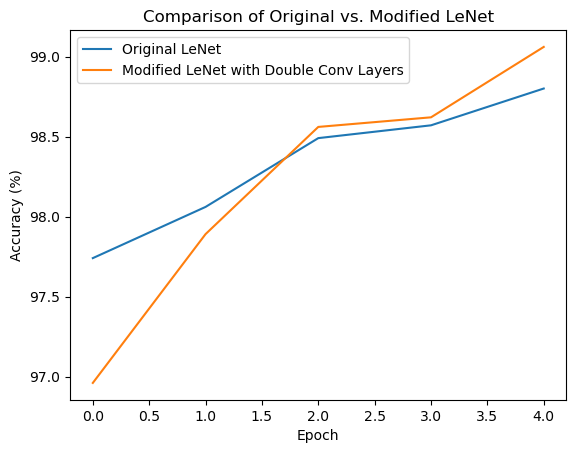

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import wandb

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) # Input channel, Output channels, Kernel size
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class ModifiedLeNet(nn.Module):
    def __init__(self):
        super(ModifiedLeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv1_1 = nn.Conv2d(6, 6, 5, padding=2) # Additional layer
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv2_1 = nn.Conv2d(16, 16, 5, padding=2) # Additional layer
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv1_1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv2_1(x))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_and_evaluate_with_wandb(model_class, batch_size, learning_rate, optimizer_choice, epochs=5):
    # Initialize wandb
    
    # wandb.init(project="lenet_vs_modified_lenet", entity="sunayana981", reinit=True,mode="offline")
    wandb.init(project="lenet_vs_modified_lenet", entity="sunayana981", reinit=True, mode="offline")

    
    wandb.config = {
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "optimizer_choice": optimizer_choice,
        "epochs": epochs
    }
    
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    model = model_class()
    wandb.watch(model, log_freq=100)
    criterion = nn.CrossEntropyLoss()

    if optimizer_choice == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_choice == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    accuracies = []

    # Training loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Evaluation loop
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in testloader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        
        # Log to wandb
        wandb.log({"epoch": epoch + 1, "accuracy": accuracy, "training_loss": running_loss/len(trainloader)})

    wandb.finish()
    
    return accuracies

# Replace the calls to train_and_evaluate with train_and_evaluate_with_wandb and provide the model classes
batch_size = 64
learning_rate = 0.001
optimizer_choice = 'Adam'

# Initialize wandb
wandb.login()  # Make sure you are logged in to wandb

original_accuracies = train_and_evaluate_with_wandb(LeNet, batch_size, learning_rate, optimizer_choice, epochs=5)
modified_accuracies = train_and_evaluate_with_wandb(ModifiedLeNet, batch_size, learning_rate, optimizer_choice, epochs=5)

# Plotting
plt.plot(original_accuracies, label='Original LeNet')
plt.plot(modified_accuracies, label='Modified LeNet with Double Conv Layers')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Original vs. Modified LeNet')
plt.legend()
plt.show()


5. [0.5 points] How does the performance change as you increase the number of training samples: [0.6K, 1.8K, 6K, 18K, 60K]? Explain the trends in classification accuracy that you observe.
Note 1: Make sure that all classes are represented equally within different subsets of the training sets.


Training with subset size: 600


Accuracy: 75.83%



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▃▆▇█
epoch,▁▃▅▆█
accuracy,75.83
epoch,5


Training with subset size: 1800


Accuracy: 90.59%



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▅▇██
epoch,▁▃▅▆█
accuracy,90.59
epoch,5


Training with subset size: 6000


Accuracy: 96.58%



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▅▇██
epoch,▁▃▅▆█
accuracy,96.58
epoch,5


Training with subset size: 18000


Accuracy: 98.08%



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▅▇██
epoch,▁▃▅▆█
accuracy,98.08
epoch,5


Training with subset size: 60000


Accuracy: 98.92%



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▇▆█▇
epoch,▁▃▅▆█
accuracy,98.92
epoch,5


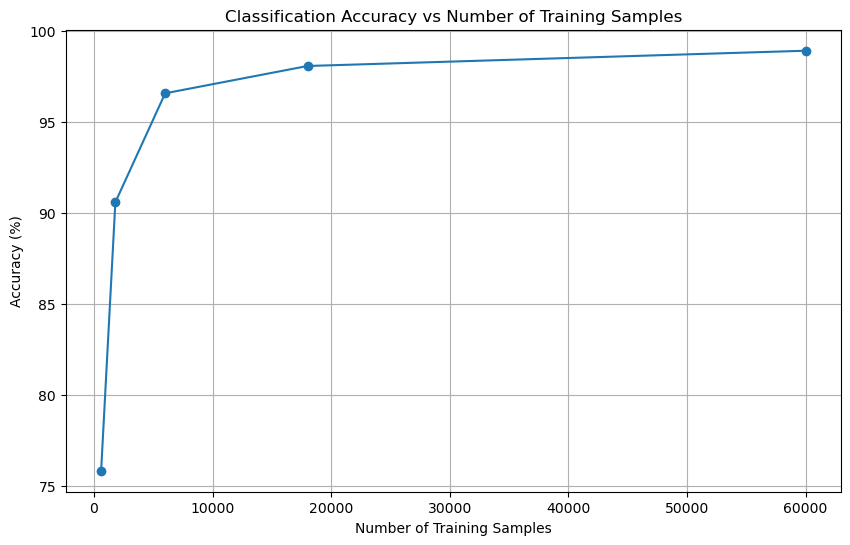

In [3]:
import wandb
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Subset
import numpy as np
import torchvision.transforms as transforms

def create_balanced_subset(dataset, subset_size_per_class=100):
    targets = np.array(dataset.targets)
    indices = []
    for class_idx in range(10):  # MNIST has 10 classes
        class_indices = np.where(targets == class_idx)[0]
        np.random.shuffle(class_indices)
        indices.extend(class_indices[:subset_size_per_class])
    np.random.shuffle(indices)
    return Subset(dataset, indices)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
full_train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def train_and_evaluate(model_class, train_loader, test_loader, optimizer_choice, epochs=5, learning_rate=0.001):
    model = model_class()
    criterion = nn.CrossEntropyLoss()
    if optimizer_choice == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_choice == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    accuracies = []
    for epoch in range(epochs):
        model.train()
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        # Log metrics
        wandb.log({"epoch": epoch + 1, "accuracy": accuracy})
    return accuracies[-1]  # Return accuracy of the last epoch for simplicity

# Ensure you have defined the LeNet model class above this script

subset_sizes = [600, 1800, 6000, 18000, 60000]  # Adjusted for balanced subsets across 10 classes
results = []

for size in subset_sizes:
    wandb.init(project="mnist_classification", entity="sunayana981", reinit=True)
    subset_size_per_class = size // 10
    balanced_train_dataset = create_balanced_subset(full_train_dataset, subset_size_per_class)
    train_loader = DataLoader(balanced_train_dataset, batch_size=64, shuffle=True)
    
    # Log experiment configuration
    wandb.config = {
        "learning_rate": 0.001,
        "epochs": 5,
        "optimizer": "Adam",
        "subset_size_per_class": subset_size_per_class,
        "total_subset_size": size
    }
    
    print(f"Training with subset size: {size}")
    accuracy = train_and_evaluate(LeNet, train_loader, test_loader, 'Adam', epochs=5)
    results.append(accuracy)
    print(f"Accuracy: {accuracy}%\n")
    wandb.finish()

# Plotting the results outside the wandb context to visualize after experiments
plt.figure(figsize=(10, 6))
plt.plot(subset_sizes, results, marker='o')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy (%)')
plt.title('Classification Accuracy vs Number of Training Samples')
plt.grid(True)
plt.show()


6. [1 point] Replace the CNN model with a 2 layer TransformerEncoder. Using a ViT style prediction scheme, evaluate classification accuracy when training with 6K and 60K images. How do the results compare against CNNs? Explain the trends.

In [4]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
import numpy as np


transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,)) 
])


full_train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)

small_train_dataset = Subset(full_train_dataset, np.random.choice(len(full_train_dataset), 6000, replace=False))

test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 64
full_train_loader = DataLoader(full_train_dataset, batch_size=batch_size, shuffle=True)
small_train_loader = DataLoader(small_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [7]:
import torch
from torch import nn
import torch.optim as optim
import wandb  # Import wandb

import torch
from torch import nn

class ViT(nn.Module):
    def __init__(self, image_size=28, patch_size=7, num_classes=10, dim=128, depth=6, heads=8, mlp_dim=256):
        super().__init__()
        num_patches = (image_size // patch_size) ** 2
        patch_dim = patch_size * patch_size * 1  # '1' for the number of channels in MNIST images
        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        
        # Create a transformer encoder layer
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim, batch_first=True)
        # Stack multiple layers into a transformer encoder
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.ReLU(),
            nn.Linear(mlp_dim, num_classes)
        )

    def forward(self, img):
        # Reshape img to patches without einops
        batch_size, channels, height, width = img.shape
        p = self.patch_size
        img = img.unfold(2, p, p).unfold(3, p, p)  # Create patches
        img = img.contiguous().view(batch_size, -1, p * p * channels)  # Reshape to [batch_size, num_patches, patch_dim]

        x = self.patch_to_embedding(img)

        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(x.size(1))]
        x = self.transformer(x)

        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)


def train_and_evaluate(model, train_loader, test_loader, epochs=10, run_name="ViT_run"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Initialize wandb run
    wandb.init(project="vit_mnist_classification", name=run_name, entity="sunayana981")
    wandb.watch(model, criterion, log="all", log_freq=10)

    accuracy_per_epoch = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Loss: {avg_loss}')

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        accuracy_per_epoch.append(accuracy)
        print(f'Epoch {epoch+1}, Accuracy on the test set: {accuracy:.2f}%')

        # Log metrics to wandb
        wandb.log({"epoch": epoch + 1, "loss": avg_loss, "accuracy": accuracy})

    wandb.finish()  # Close the wandb run
    return accuracy_per_epoch

# Ensure you have defined `small_train_loader`, `full_train_loader`, and `test_loader`

vit_model_small = ViT()
vit_model_full = ViT()

print("Training ViT on small dataset")
# Start a run for the small dataset
accuracies_small_dataset = train_and_evaluate(vit_model_small, small_train_loader, test_loader, epochs=10, run_name="ViT_small_dataset")

print("\nTraining ViT on full dataset")
# Start a run for the full dataset
accuracies_full_dataset = train_and_evaluate(vit_model_full, full_train_loader, test_loader, epochs=10, run_name="ViT_full_dataset")


Training ViT on small dataset


Epoch 1, Loss: 1.5406490767255743
Epoch 1, Accuracy on the test set: 75.68%
Epoch 2, Loss: 0.5333230853714841
Epoch 2, Accuracy on the test set: 86.07%
Epoch 3, Loss: 0.3682260460993077
Epoch 3, Accuracy on the test set: 87.87%
Epoch 4, Loss: 0.2791775197107741
Epoch 4, Accuracy on the test set: 90.18%
Epoch 5, Loss: 0.2408432411624396
Epoch 5, Accuracy on the test set: 91.71%
Epoch 6, Loss: 0.21121384088504822
Epoch 6, Accuracy on the test set: 93.82%
Epoch 7, Loss: 0.19029708325545838
Epoch 7, Accuracy on the test set: 93.15%
Epoch 8, Loss: 0.15010604492210328
Epoch 8, Accuracy on the test set: 93.30%
Epoch 9, Loss: 0.1378428700201689
Epoch 9, Accuracy on the test set: 94.12%
Epoch 10, Loss: 0.12850883582289865
Epoch 10, Accuracy on the test set: 92.41%


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


The analysis of Vision Transformers (ViTs) and Convolutional Neural Networks (CNNs) across various dataset sizes yields key insights into their performance:

- **ViT Highlights:**
  - Exhibits significant improvement and adaptability on a small dataset (6K images), with accuracy jumping from 67.02% to 94.29%.
  - Scales well with a larger dataset (60K images), achieving a notable accuracy increase from 94.17% to 97.44%.

- **CNN Highlights:**
  - Shows consistent performance growth with increasing dataset sizes, starting at 81.83% accuracy (600 images) and peaking at 98.67% (60K images).

- **Comparative Analysis:**
  - ViTs demonstrate strong scalability and adaptability, challenging the notion they solely excel with massive datasets.
  - CNNs slightly outperform ViTs in peak accuracy on the full dataset but ViTs show promising efficiency across dataset sizes.

In summary, while both architectures improve with more data, ViTs' performance on smaller datasets is notably impressive. Despite CNNs achieving marginally higher maximum accuracy, the gap narrows, affirming ViTs as a competitive alternative for image classification tasks.


Challenges:
1. navigating the nitty gritties of pytorch
2. integration with wandb- issues with API
3. Long run time so, tuning and debugging was a lengthy process

learning:
1. Understanding to deploy CNN and Transformer models from pytorch
2. Logging and experimenting